# Tutorial: data procesing
Author info: Jiaqi Cai@Department of Physics, MIT, email address jiaqic[at]mit.edu.

This tutorial shows how to use this package to perform multidimensional data analysis. The example_database is generated by quick start. 

# Database initialization
First, we list all available databases under MeasureItHome/databases and show the standard qcodes way to initialize and load databases.

In [ ]:
# Standard QCoDeS imports for database and dataset operations
from pathlib import Path
import os
import numpy as np

# Core QCoDeS imports
import qcodes as qc
from qcodes.dataset import (
    initialise_or_create_database_at,
    load_or_create_experiment,
    load_experiment,
    load_experiment_by_name,
    load_last_experiment,
    experiments,
    new_experiment,
    connect,
    Measurement,
    load_by_run_spec,
    load_by_id,
    load_by_guid,
    plot_dataset
)

# MeasureIt imports
from MeasureIt.util import init_database

print(f"QCoDeS version: {qc.__version__}")
print(f"Current QCoDeS database location: {qc.config.core.db_location}")

In [ ]:
databases_path = Path(os.environ['MeasureItHome']) / "databases"
db_files = sorted(databases_path.glob("*.db"))
print(f"🗃️ Database files in {databases_path}:")
print("=" * 50)
for i, db_file in enumerate(db_files, 1):
    print(f"{i:2}. {db_file.name}")

In [ ]:
# Choose a database file (replace with your desired .db file)
databases_path = Path(os.environ['MeasureItHome']) / "databases"
db_file = databases_path / "Example_database.db"  

# Load the database
initialise_or_create_database_at(db_file)
print(f"📊 Loaded database: {db_file.name}")

# Show experiments in the database


## List experiments and datasets

In [58]:
import helper
importlib.reload(helper)
dataset = load_by_id(2)
helper.print_metadata(dataset)

In [59]:
helper.print_all_metadata()

# Plot 0D

In [61]:
dataset = load_by_id(1)
helper.print_metadata(dataset)

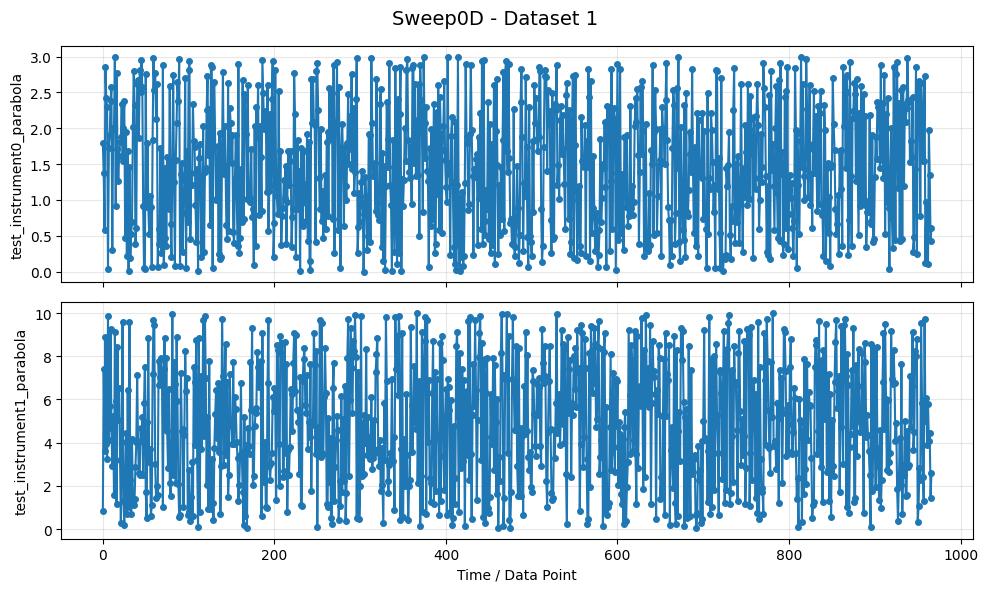

In [63]:
import matplotlib.pyplot as plt

data = dataset.get_parameter_data()
n_params = len(data)
fig, axes = plt.subplots(n_params, 1, figsize=(10, 3*n_params), sharex=True)

if n_params == 1:
    axes = [axes]

for ax, (param_name, param_data) in zip(axes, data.items()):
    values = list(param_data.values())[0]
    ax.plot(values, 'o-', markersize=4)
    ax.set_ylabel(param_name)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time / Data Point')
fig.suptitle(f'Sweep0D - Dataset {dataset.run_id}', fontsize=14)
plt.tight_layout()
plt.show()

# Plot 1D

In [64]:
dataset = load_by_id(2)
helper.print_metadata(dataset)

In [76]:
metadata

{'class': 'Sweep1D',
 'module': 'MeasureIt.sweep1d',
 'attributes': {'inter_delay': 0.05,
  'save_data': True,
  'plot_data': True,
  'plot_bin': 4,
  'bidirectional': True,
  'continual': False,
  'x_axis_time': 0},
 'set_param': {'param': 'x',
  'instr_module': 'qcodes.instrument_drivers.mock_instruments',
  'instr_class': 'MockParabola',
  'instr_name': 'test_instrument0',
  'start': 0,
  'stop': 10,
  'step': 0.02},
 'follow_params': {'parabola': ['test_instrument1',
   'qcodes.instrument_drivers.mock_instruments',
   'MockParabola']}}

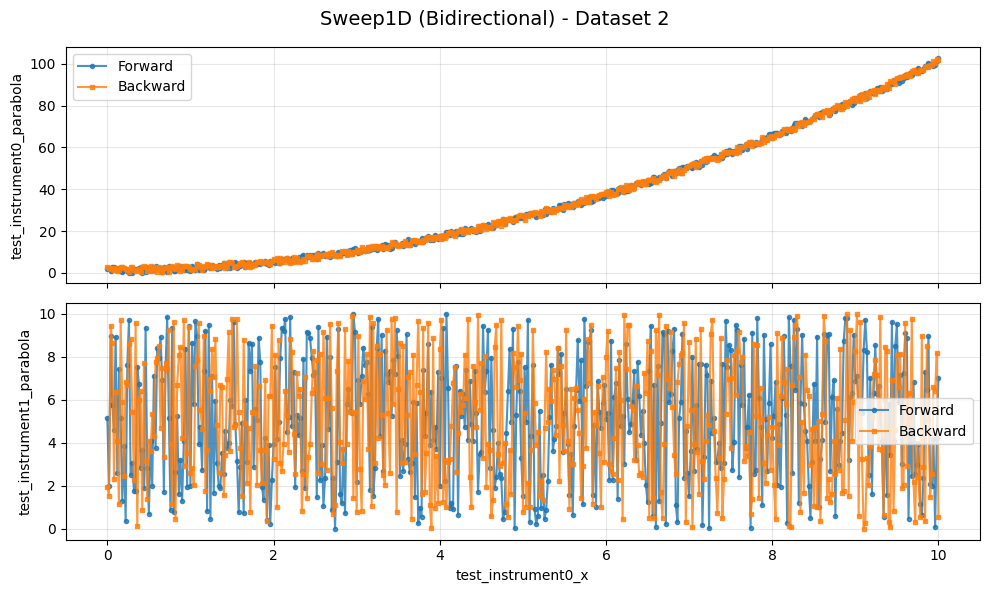

In [77]:
import matplotlib.pyplot as plt
import json
import numpy as np

data = dataset.get_parameter_data()
metadata = json.loads(dataset.metadata['measureit'])
x_param_info = metadata['set_param']
x_param_name = f"{x_param_info['instr_name']}_{x_param_info['param']}"
is_bidirectional = metadata['attributes'].get('bidirectional', False)

# Get x data from any parameter that has it as setpoint
x_data = None
for param_data in data.values():
    if x_param_name in param_data:
        x_data = param_data[x_param_name]
        break

measured_params = [p for p in data.keys() if p != 'time']
n_params = len(measured_params)
fig, axes = plt.subplots(n_params, 1, figsize=(10, 3*n_params), sharex=True)

if n_params == 1:
    axes = [axes]

for ax, param_name in zip(axes, measured_params):
    y_data = data[param_name][param_name]
    
    if is_bidirectional:
        # Plot forward and backward sweep differently
        mid_point = len(x_data) // 2
        ax.plot(x_data[:mid_point], y_data[:mid_point], 'o-', markersize=3, label='Forward', alpha=0.8)
        ax.plot(x_data[mid_point:], y_data[mid_point:], 's-', markersize=3, label='Backward', alpha=0.8)
        ax.legend()
    else:
        ax.plot(x_data, y_data, 'o-', markersize=4)
    
    ax.set_ylabel(param_name)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel(x_param_name)
title = f'Sweep1D {"(Bidirectional)" if is_bidirectional else ""} - Dataset {dataset.run_id}'
fig.suptitle(title, fontsize=14)
plt.tight_layout()
plt.show()

## Plot Simul

In [78]:
dataset = load_by_id(3)
helper.print_metadata(dataset)

In [79]:
dataset.metadata

{'measureit': '{"class": "SimulSweep", "module": "MeasureIt.simul_sweep", "attributes": {"inter_delay": 0.05, "save_data": true, "plot_data": true, "plot_bin": 4, "bidirectional": true, "continual": false}, "set_params": {"x": {"start": 0, "stop": 10, "step": 0.04, "setpoint": -0.04, "instr_module": "qcodes.instrument_drivers.mock_instruments", "instr_class": "MockParabola", "instr_name": "test_instrument1"}}, "follow_params": {"x": ["test_instrument1", "qcodes.instrument_drivers.mock_instruments", "MockParabola"], "parabola": ["test_instrument1", "qcodes.instrument_drivers.mock_instruments", "MockParabola"]}}'}

Found 1 set parameters: ['test_instrument1_x']
Found 3 follow parameters: ['test_instrument0_parabola', 'test_instrument1_parabola', 'test_instrument1_x']


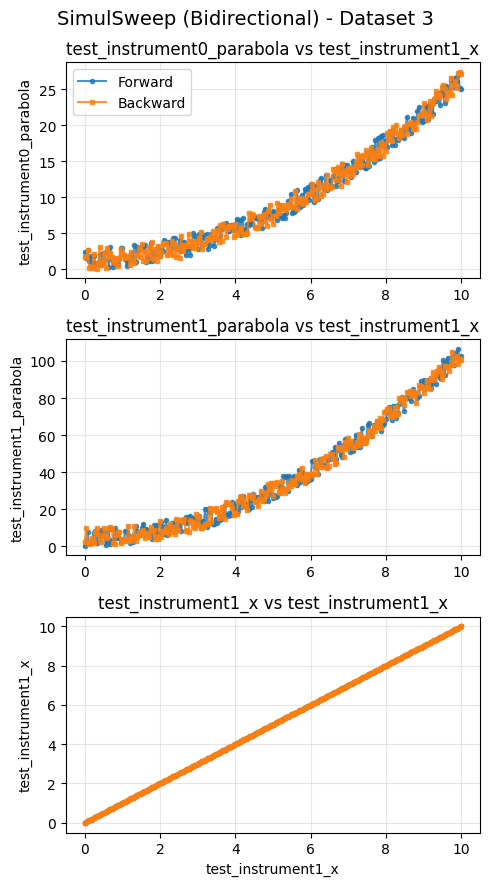

In [83]:
import matplotlib.pyplot as plt
import json

data = dataset.get_parameter_data()
metadata = json.loads(dataset.metadata['measureit'])
set_params = metadata['set_params']
is_bidirectional = metadata['attributes'].get('bidirectional', False)

# Get all set parameter names and their data
x_params_data = {}
for param, info in set_params.items():
    param_name = f"{info['instr_name']}_{param}"
    # Find this parameter in any of the data entries
    for data_key, data_dict in data.items():
        if param_name in data_dict:
            x_params_data[param_name] = data_dict[param_name]
            break

# Get follow parameter names (excluding time)
follow_param_names = [p for p in data.keys() if p != 'time']

n_x = len(x_params_data)
n_follow = len(follow_param_names)

print(f"Found {n_x} set parameters: {list(x_params_data.keys())}")
print(f"Found {n_follow} follow parameters: {follow_param_names}")

fig, axes = plt.subplots(n_follow, n_x, figsize=(5*n_x, 3*n_follow))

if n_x == 1 and n_follow == 1:
    axes = [[axes]]
elif n_x == 1:
    axes = [[ax] for ax in axes]
elif n_follow == 1:
    axes = [axes]

for i, follow_param in enumerate(follow_param_names):
    y_data = data[follow_param][follow_param]
    
    for j, (x_param_name, x_data) in enumerate(x_params_data.items()):
        if is_bidirectional:
            # Plot forward and backward sweep differently
            mid_point = len(x_data) // 2
            axes[i][j].plot(x_data[:mid_point], y_data[:mid_point], 'o-', markersize=3, label='Forward', alpha=0.8)
            axes[i][j].plot(x_data[mid_point:], y_data[mid_point:], 's-', markersize=3, label='Backward', alpha=0.8)
            if i == 0 and j == 0:  # Only show legend once
                axes[i][j].legend()
        else:
            axes[i][j].plot(x_data, y_data, 'o-', markersize=4)
        
        axes[i][j].set_ylabel(follow_param if j == 0 else '')
        axes[i][j].set_xlabel(x_param_name if i == n_follow-1 else '')
        axes[i][j].set_title(f'{follow_param} vs {x_param_name}')
        axes[i][j].grid(True, alpha=0.3)

title = f'SimulSweep {"(Bidirectional)" if is_bidirectional else ""} - Dataset {dataset.run_id}'
fig.suptitle(title, fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2D

In [ ]:
dataset = load_by_id(6)
helper.print_metadata(dataset)

## Plot arbitrary sequence

In [ ]:
%load_ext instrmcp.extensions
%mcp_status

In [ ]:
%mcp_unsafe
%mcp_start